In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pip import _internal
#_internal.main(['list'])
from numba import jit, jitclass, int32, float32

spec = [
    ('n_contexts', int32),   
    ('n_arms', int32),
    ('belief', float32[:]),
]


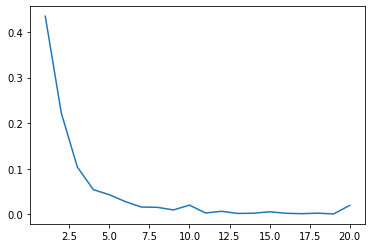

In [172]:
# load env dist
N = 20
ngram = np.load('data/ngram.npy')
env = ngram[0:N] / np.sum(ngram[0:N])
plt.plot(1 + np.arange(N),env)

Beta-Bernoulli Bandits 

In [149]:
from numpy.random import beta
# Standard bandit
class Beta_Bandit:
    def __init__(self, n_contexts, n_arms):
        self.n_contexts = n_contexts
        self.n_arms = n_arms
        self.belief = self.ini_belief()
        
    def update_belief(self, context, arm, r):
        self.belief[context][arm]['alpha'] += r
        self.belief[context][arm]['beta'] += 1 - r
        
    def ini_belief(self):
        belief = {}
        for context in range(self.n_contexts):
            belief[context] = {}
            for arm in range(self.n_arms):
                belief[context][arm] = {'alpha' : 1.0, 'beta' : 1.0}
        return belief 
    
    def sample(self, context):
        thetas = []
        for arm in range(self.n_arms):
            thetas.append(beta(self.belief[context][arm]['alpha'], self.belief[context][arm]['beta']))
        return np.argmax(np.array(thetas))
    
    def argmax(self, context):
        thetas = []
        for arm in range(self.n_arms):
            mean = self.belief[context][arm]['alpha'] / (self.belief[context][arm]['alpha'] + self.belief[context][arm]['beta'])
            thetas.append(mean)
        return np.argmax(np.array(thetas))

    def fraction_response(self, T=1000):
        # p(w|i), "How often word w is used to describe context i
        fraction_response = {}
        for context in range(self.n_contexts):
            counts = np.zeros(self.n_arms)
            for _ in range(T):
                arm = self.sample(context=context)
                counts[arm] += 1
            fraction_response[context] = counts/T
        return fraction_response
            
            
def binary(context, guess):
    return int(context == guess)

def eval_bandits(sender, listener, n_contexts, n_arms, reward_func=binary):
    sender_mapping = {}
    listener_mapping = {}
    partition = {}
    total_reward = 0
    for context in range(n_contexts):
        # Generate message
        arm = sender.argmax(context=context)
        sender_mapping[context] = arm
        # Generate response 
        guess = listener.argmax(context=arm)
        if arm not in list(listener_mapping.keys()):
            listener_mapping[arm] = [guess]
        else:
            listener_mapping[arm] += [guess]
            
        total_reward += reward_func(context, guess)
        # Partitions 
        if arm not in list(partition.keys()):
            partition[arm] = [context]
        else:
            partition[arm] += [context]

    return partition, total_reward, sender_mapping, listener_mapping

def compute_ranges(partition):
    # Clean-up
    ranges = {}
    for w in list(partition.keys()):
        ranges[str(w)] = []
        state = 'out'
        numbers = partition[w]
        numbers.sort()
        state = 'out'
        interval = []
        for n in numbers:
            if not interval:
                interval += [n]
                start = n
                prev = n
            else:
                if prev + 1 != n:
                    ranges[str(w)] += [(start + 1, prev + 1)]
                    start = n
                prev = n
        ranges[str(w)] += [(start+1, prev+1)]
    return ranges

def train_bandits(sender, listener, env, N, W, reward_func=binary):
    regret = []
    for i in range(T):
        # Play
        context = np.random.choice(np.arange(N), p = env)
        word = sender.sample(context=context)
        guess = listener.sample(context=word)
        # Compute reward/regret
        r = reward_func(context, guess)
        regret.append(1 - r)
        # Update
        sender.update_belief(context=context, arm=word, r=r)
        listener.update_belief(context=word, arm=guess, r=r)

    regret = np.array(regret)
    total_regret = np.cumsum(regret)
    return total_regret    

[0.1030052822444755, 0.5022050771900315]
{0: {0: {'alpha': 1.0, 'beta': 9.0}, 1: {'alpha': 475.0, 'beta': 519.0}}}


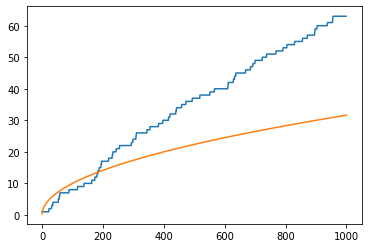

In [119]:
# Toy problem 
T = 1000
W = 2
thetas = []
arms = []
for arm in range(W):
    thetas.append(np.random.uniform(0.1, 0.7))
    arms.append(arm)

theta = np.array(thetas)
print(thetas)
bandit = Beta_Bandit(1, W)
context = 0
regret = []
for i in range(T):
    outcomes = []
    arm = bandit.sample(context=context)
    if np.random.uniform() < theta[arm]:
        r = 1
    else:
        r = 0
    outcomes.append(r)
    for a in arms:
        if a != arm:
            if np.random.uniform() < theta[a]:
                outcomes.append(1)
            else:
                outcomes.append(0)
    r_opt = np.max(np.array(outcomes))
    regret.append(r_opt - r)
    # Update
    bandit.update_belief(context=context, arm=arm, r=r)

regret = np.array(regret)
total_regret = np.cumsum(regret)
print(bandit.belief)
plt.plot(total_regret)
x = np.linspace(0.1, T, T)
O_bound = np.sqrt(x)
plt.plot(x, O_bound)

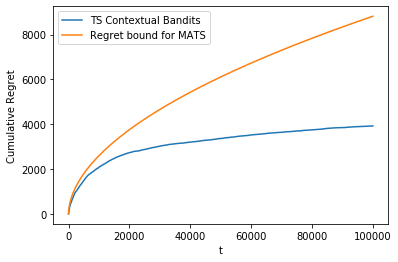

In [174]:
# Test run
T = 100000
W = 20

sender = Beta_Bandit(N, W)
listener = Beta_Bandit(W, N)
total_regret = train_bandits(sender, listener, env, N, W)

# eval
partition, total_reward, sender_mapping, listener_mapping = eval_bandits(sender, listener, N, W, reward_func=binary)
partition = compute_ranges(partition)

plt.xlabel('t')
plt.ylabel('Cumulative Regret')
plt.plot(total_regret) 
x = np.linspace(0.1, T, T)
O_bound = 1/3  * np.sqrt(N ** (2) * x * np.log(N ** (2) * x))
plt.plot(x, O_bound)
plt.legend(['TS Contextual Bandits', 'Regret bound for MATS'])

In [ ]:
sender.belief

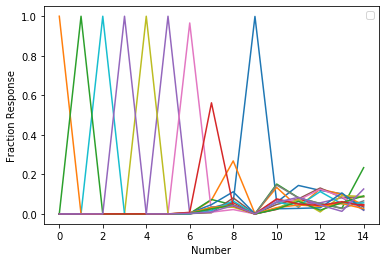

In [169]:
# Fraction of response
fraction_response = sender.fraction_response(T=1000)
fr = []
for context in range(sender.n_contexts):
    fr.append(fraction_response[context])
fr = np.array(fr)
plt.xlabel('Number')
plt.ylabel('Fraction Response')
plt.legend(["Word" + str(w) for w in range(sender.n_contexts)])
plt.plot(fr)

In [167]:
# Plot partition
for w in list(partition.keys()):
    print('Word: {0} partition: {1}'.format(w, partition[str(w)]))
    print('Word: {0} Listener guess: {1}'.format(w, 1 + listener_mapping[int(w)][0]))
  
print('Total unweighted reward: {}'.format(total_reward))


Word: 16 partition: [(1, 1)]
Word: 16 Listener guess: 1
Word: 1 partition: [(2, 2)]
Word: 1 Listener guess: 2
Word: 15 partition: [(3, 3)]
Word: 15 Listener guess: 3
Word: 9 partition: [(4, 4)]
Word: 9 Listener guess: 4
Word: 3 partition: [(5, 5)]
Word: 3 Listener guess: 5
Word: 8 partition: [(6, 6)]
Word: 8 Listener guess: 6
Word: 11 partition: [(7, 7), (13, 13)]
Word: 11 Listener guess: 7
Word: 2 partition: [(8, 8)]
Word: 2 Listener guess: 8
Word: 10 partition: [(9, 9)]
Word: 10 Listener guess: 9
Word: 17 partition: [(10, 10)]
Word: 17 Listener guess: 10
Word: 4 partition: [(11, 11)]
Word: 4 Listener guess: 7
Word: 5 partition: [(12, 12), (15, 15)]
Word: 5 Listener guess: 15
Word: 6 partition: [(14, 14)]
Word: 6 Listener guess: 4
Total unweighted reward: 11


Bandits with continous reward

In [ ]:
# Reward function given action
a = 4
x = np.linspace(1, 100, 100)
y = (1 - np.abs(a - x) / 100)
rewards, inverse = np.unique(y, return_inverse=True)
reward_probs = np.zeros(rewards.shape)
for i in range(100):
    p = env[i]
    j = inverse[i]
    reward_probs[j] += p
plt.plot(rewards, reward_probs)

In [ ]:
# Contextual with linear reward Bandit (Not-used)
class LinearBandit:
    def __init__(self, context_dim, n_arms, v=1):
        self.context_dim = context_dim
        self.n_arms = n_arms
        self.v = v
        self.ini_belief()
        
    def ini_belief(self):
        belief = {}
        for arm in range(self.n_arms):
            belief[arm] = {'B' : np.eye(self.context_dim), 'mu' : np.zeros(self.context_dim), 'f' : np.zeros(self.context_dim)}
        self.belief = belief
        
    def sample(self, context):
        sampled_reward = []
        for arm in range(self.n_arms):
            B = self.belief[arm]['B']
            mu = self.belief[arm]['mu']
            theta = np.random.multivariate_normal(mu, (self.v ** 2) * np.linalg.inv(B))
            reward = theta.dot(context)
            sampled_reward.append(reward)
        return np.argmax(np.array(sampled_reward))
    
    def update_belief(self, context, arm, r):
        B = self.belief[arm]['B']
        mu = self.belief[arm]['mu']
        f = self.belief[arm]['f']
        
        B = B + np.matmul(context, np.transpose(context))
        f = f + context * reward
        mu = np.matmul(np.linalg.inv(B), f)
        
        self.belief[arm]['B'] = B
        self.belief[arm]['mu'] = mu
        self.belief[arm]['f'] = f
        


/Users/caremil/.pyenv/versions/finance/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


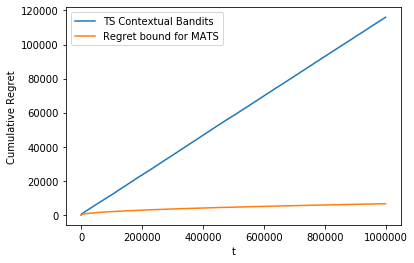

In [162]:
# Test run with abs dist

# Absolute distance reward
def abs_dist(context, guess):
    return 1 - np.abs(context - guess)/N

T = 10000
W = 5

sender = Beta_Bandit(N, W)
listener = Beta_Bandit(W, N)
total_regret = train_bandits(sender, listener, env, N, W)

# eval
partition, total_reward, sender_mapping, listener_mapping = eval_bandits(sender, listener, N, W, reward_func=abs_dist)
partition = compute_ranges(partition)

plt.xlabel('t')
plt.ylabel('Cumulative Regret')
plt.plot(total_regret)
x = np.linspace(0.1, T, T)
O_bound = 1/10  * np.sqrt(N ** (2) * x * np.log(N ** (2) * x))
plt.plot(x, O_bound)
plt.legend(['TS Contextual Bandits', 'Regret bound for MATS'])

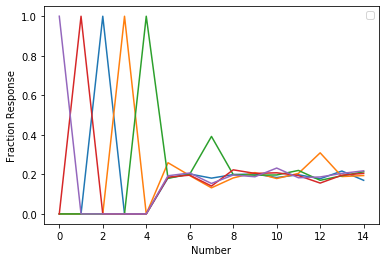

In [163]:
# Fraction of response
fraction_response = sender.fraction_response(T=1000)
fr = []
for context in range(sender.n_contexts):
    fr.append(fraction_response[context])
fr = np.array(fr)
plt.xlabel('Number')
plt.ylabel('Fraction Response')
plt.legend(["Word" + str(w) for w in range(sender.n_contexts)])
plt.plot(fr)

In [164]:
# Plot partition
for w in list(partition.keys()):
    print('Word: {0} partition: {1}'.format(w, partition[str(w)]))
    print('Word: {0} Listener guess: {1}'.format(w, 1 + listener_mapping[int(w)][0]))
  
print('Total unweighted reward: {}'.format(total_reward))



Word: 4 partition: [(1, 1), (7, 7), (11, 11), (15, 15)]
Word: 4 Listener guess: 1
Word: 3 partition: [(2, 2), (9, 9)]
Word: 3 Listener guess: 2
Word: 0 partition: [(3, 3), (14, 14)]
Word: 0 Listener guess: 3
Word: 1 partition: [(4, 4), (6, 6), (13, 13)]
Word: 1 Listener guess: 4
Word: 2 partition: [(5, 5), (8, 8), (10, 10), (12, 12)]
Word: 2 Listener guess: 5
Total unweighted reward: 10.066666666666668
